Download link for the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [4]:
import torch
import tqdm
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler

In [5]:
torch.cuda.get_device_name()

'Tesla T4'

In [6]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
len(df)

284807

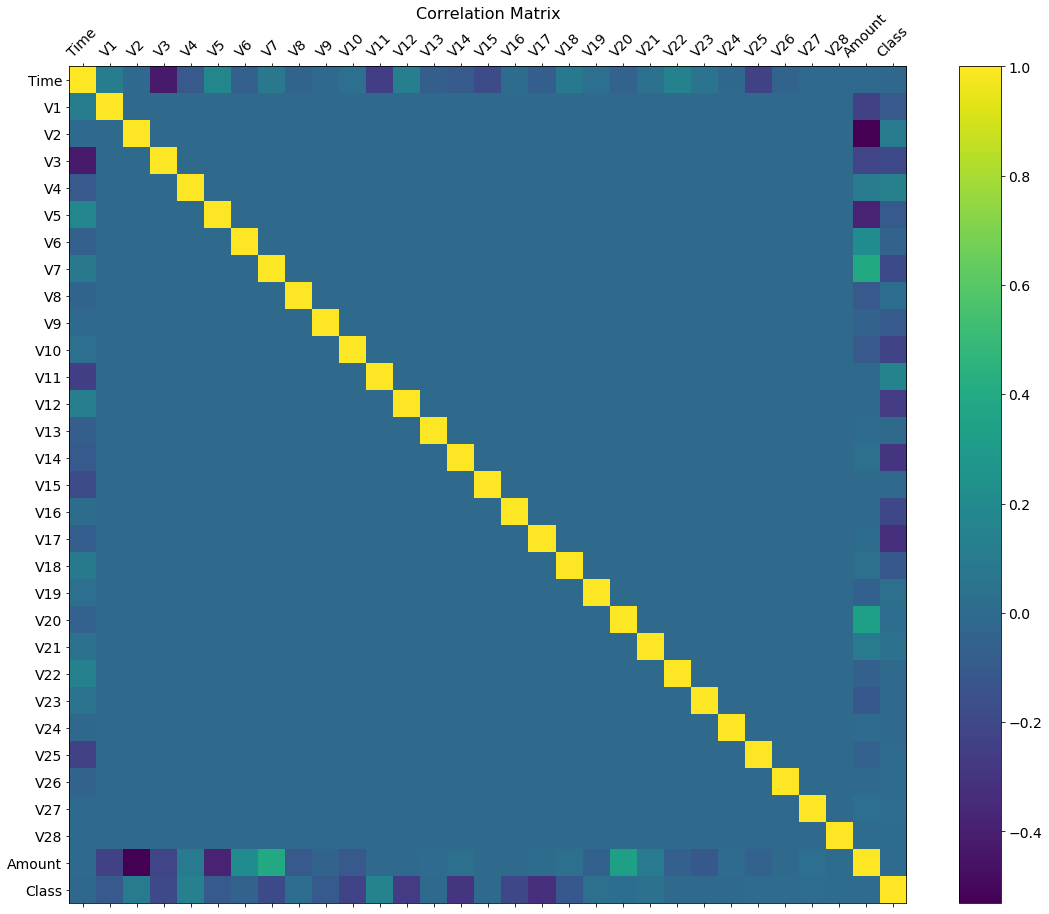

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [9]:
df.corr()["Class"]

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

In [10]:
labels = df["Class"].tolist()
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
labels.count(0), labels.count(1), labels.count(0) / labels.count(1)

(284315, 492, 577.8760162601626)

In [12]:
class LoadDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.df.drop(["Time"], axis=1, inplace=True)

        self.pca_coms = self.df.drop(["Class"], axis=1).values
        self.labels = self.df["Class"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        pca_com = self.pca_coms[index]
        label = self.labels[index]

        pca_com = torch.FloatTensor(pca_com)
        label = torch.tensor(label)

        return pca_com, label

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5
batch_size = 32
lr = 3e-5

In [14]:
device

device(type='cuda')

In [15]:
dataset = LoadDataset("creditcard.csv")
train_size = int(0.7 * len(dataset))
train_data, val_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [16]:
len(train_data), len(val_data)

(199364, 85443)

In [17]:
x, y = dataset[42]
x, y

(tensor([-0.6079,  1.0313,  1.7404,  1.2321,  0.4186,  0.1192,  0.8509, -0.1763,
         -0.2435,  0.1485, -0.3870,  0.3983,  0.4819, -0.3654,  0.2355, -1.3478,
          0.5046, -0.7984,  0.7597,  0.2543, -0.0873,  0.2583, -0.2648,  0.1183,
          0.1735, -0.2170,  0.0943, -0.0330, 14.8000]), tensor(0))

In [18]:
x.shape, y.shape

(torch.Size([29]), torch.Size([]))

In [20]:
class_weights = [1, labels.count(0) / labels.count(1)]
train_sample_weights = [0] * len(train_data)
val_sample_weights = [0] * len(val_data)

for i, (data, label) in enumerate(train_data):
    class_weight = class_weights[label.item()]
    train_sample_weights[i] = class_weight

for i, (data, label) in enumerate(val_data):
    class_weight = class_weights[label.item()]
    val_sample_weights[i] = class_weight
 
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)
val_sampler = WeightedRandomSampler(val_sample_weights, num_samples=len(val_sample_weights), replacement=True)

In [21]:
train_batches = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_batches = DataLoader(val_data, batch_size=batch_size, sampler=val_sampler)

In [22]:
for batch in train_batches:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([32, 29])
torch.Size([32])


In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(29, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = self.relu(x)

        x = self.dropout(self.fc2(x))
        x = self.relu(x)

        x = self.fc3(x)
        return x

In [24]:
net = Net().to(device)

In [25]:
inp = torch.randn(1, 29).to(device)
output = net(inp)
output.shape

torch.Size([1, 2])

In [26]:
num_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)
num_parameters

10498

In [27]:
opt = torch.optim.Adam(net.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

In [28]:
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

    return acc.item()

In [29]:
def loop(net, batches, train):
    batch_losses = []
    batch_accs = []

    if train:
        print("Train Loop:")
        print("")
        net.train()

        for X, y in tqdm.tqdm(batches, total=len(batches)):
            X = X.to(device)
            y = y.to(device)

            preds = net(X)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            batch_losses.append(loss.item())
            batch_accs.append(acc)

    else:
        print("Validation Loop:")
        print("")
        net.eval()

        with torch.no_grad():
            for X, y in tqdm.tqdm(batches, total=len(batches)):
                X = X.to(device)
                y = y.to(device)

                preds = net(X)
                loss = loss_fn(preds, y)
                acc = get_accuracy(preds, y)

                batch_losses.append(loss.item())
                batch_accs.append(acc) 

    print("")
    print("")
    
    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs)

In [30]:
for epoch in range(epochs):
    train_loss, train_acc = loop(net, train_batches, True)
    val_loss, val_acc = loop(net, val_batches, False)
    
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    print("")

  0%|          | 1/6231 [00:00<10:42,  9.70it/s]

Train Loop:



  3%|▎         | 70/2671 [00:00<00:03, 693.61it/s]



Validation Loop:



  0%|          | 21/6231 [00:00<00:30, 206.15it/s]



epoch: 0 | train_loss: 1.3594 | train_acc: 0.7104 | val_loss: 0.4101 | val_acc: 0.8782

Train Loop:



  3%|▎         | 85/2671 [00:00<00:03, 848.51it/s]



Validation Loop:



  0%|          | 19/6231 [00:00<00:33, 185.81it/s]



epoch: 1 | train_loss: 0.4885 | train_acc: 0.8766 | val_loss: 0.2418 | val_acc: 0.9492

Train Loop:



  2%|▏         | 62/2671 [00:00<00:04, 618.20it/s]



Validation Loop:



  0%|          | 25/6231 [00:00<00:24, 248.99it/s]



epoch: 2 | train_loss: 0.2871 | train_acc: 0.9162 | val_loss: 0.1798 | val_acc: 0.9508

Train Loop:



  3%|▎         | 87/2671 [00:00<00:02, 865.03it/s]



Validation Loop:



  0%|          | 24/6231 [00:00<00:26, 235.07it/s]



epoch: 3 | train_loss: 0.2158 | train_acc: 0.9296 | val_loss: 0.1508 | val_acc: 0.9488

Train Loop:



  3%|▎         | 88/2671 [00:00<00:02, 875.46it/s]



Validation Loop:



100%|██████████| 2671/2671 [00:03<00:00, 883.52it/s]



epoch: 4 | train_loss: 0.1842 | train_acc: 0.9357 | val_loss: 0.1354 | val_acc: 0.9507



In [31]:
net.eval()
true_preds = []
fraud_preds = []

for x, y in tqdm.tqdm(val_data, total=len(val_data)):
    if y.item() == 0: # only true pca_coms
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = net(x)
        true_preds.append(pred.argmax(dim=1).item())

    elif y.item() == 1: # only fraud pca_coms
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = net(x)
        fraud_preds.append(pred.argmax(dim=1).item())

100%|██████████| 85443/85443 [00:31<00:00, 2695.39it/s]


In [32]:
true_acc = round(true_preds.count(0) / len(true_preds), 4)
fraud_acc = round(fraud_preds.count(1) / len(fraud_preds), 4)
print(true_acc, fraud_acc)

0.9761 0.9231
